In [25]:
import os
import json
import pandas as pd
import numpy as np
import json
import logging ### to monitor the code
from bs4 import BeautifulSoup
import xml.etree.cElementTree as ET
import pickle
import math
import random
import sys
import csv
import unicodedata
import requests
from urllib.request import urlopen 
import io
import getpass
import re
from collections import defaultdict
from itertools import islice # to iterate through dicts

import nltk
from nltk.collocations import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

import sddk

In [45]:
#from anda import gr
# OR uncomment the following:
script_url = "https://raw.githubusercontent.com/sdam-au/anda_py/master/anda/gr.py"
exec(requests.get(script_url).content)

In [26]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [27]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:

# (1) read the file and parse its content
file_data = conf[0].get("https://sciencedata.dk/files/ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)

ECCE_AGT_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1KPpPaeX215HR_fVrakvJp8aB6oZDhHFTcBw0MKLw6as/edit?usp=sharing")

# Import the data

In [28]:
AGT = sddk.read_file("SDAM_data/AGT/AGT_20201020.json", "df", conf)
AGT.head(5)

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,wordcount,lemmata,lemmata_wordcount,lemmatized_sentences
0,tlg0001.tlg001.perseus-grc2.xml,Apollonius Rhodius,Argonautica; Argonautica,"ἀρχόμενος σέο, Φοῖβε, παλαιγενέων κλέα φωτῶν μ...",tlg0001,tlg0001.tlg001,3 B.C.,-2.5,{'-2.5': 1},-2.5,pagan,38822,"[σέο, φοῖβος, παλαιγενής, κλέος, φάος, μιμνήσκ...",24237,"[[σέο, φοῖβος, παλαιγενής, κλέος, φάος, μιμνήσ..."
1,tlg0003.tlg001.perseus-grc2.xml,Thucydides,The Peloponnesian War; Historiae in two volumes,Θουκυδίδης Ἀθηναῖος ξυνέγραψε τὸν πόλεμον τῶν ...,tlg0003,tlg0003.tlg001,5 B.C.,-4.5,{'-4.5': 1},-4.5,pagan,150160,"[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελο...",68166,"[[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελ..."
2,tlg0004.tlg001.perseus-grc1.xml,Diogenes Laertius,Lives of Eminent Philosophers; Lives of Eminen...,ΒΙΩΝ ΚΑΙ ΓΝΩΜΩΝ ΤΩΝ ΕΝ ΦΙΛΟΣΟΦΙΑΙ ΕΥΔΟΚΙΜΗΣΑΝΤ...,tlg0004,tlg0004.tlg001,A.D. 3,2.5,{'2.5': 1},NaN,,111053,"[βία, ἀκή, γνώμη, ἕνος, φιλοσοφία, εὐδοκιμέω, ...",55580,"[[βία, ἀκή, γνώμη, ἕνος, φιλοσοφία, εὐδοκιμέω,..."
3,tlg0005.tlg001.perseus-grc1.xml,Theocritus,Idylls ; Idylls,Θύρσις ἢ ᾠδή Θύρσις ̔Αδύ τι τὸ ψιθύρισμα καὶ ἁ...,tlg0005,tlg0005.tlg001,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,19514,"[θύρσις, ἀοιδή, θύρσις, αδύ, ψιθύρισμα, πίτυς,...",12478,"[[θύρσις, ἀοιδή, θύρσις, αδύ, ψιθύρισμα, πίτυς..."
4,tlg0005.tlg002.perseus-grc1.xml,Theocritus,Epigrams ; Idylls,α παλ ϝι.336 τὰ ῥόδα τὰ δροσόεντα καὶ ἁ κατάπυ...,tlg0005,tlg0005.tlg002,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,1807,"[παλ, ϝι, ῥοδῆ, δροσόεντα, κατάπυκνος, ἐκεῖνος...",1137,"[[παλ, ϝι], [ῥοδῆ, δροσόεντα, κατάπυκνος, ἐκεῖ..."


# δικ* over the whole corpus

In [35]:
# whole corpus as a list of lemmata
AGT_lemmata_list = np.concatenate(AGT["lemmata"].tolist())
len(AGT_lemmata_list)

14114036

In [94]:
match_pattern = "(κατα|ὑπό|ἐκ|ἀ|ἄ|ἀντί|^)δ[ι|ί]κ(α|ά|ο|ό|ί|έ|η)(.+)?"

dik_words = [word for word in AGT_lemmata_list if re.search(match_pattern, word)]
dik_words_df = pd.DataFrame(nltk.FreqDist(dik_words).most_common(), columns=["lemma", "count"])
dik_words_df.head(5)

,lemma,count
0,δίκαιος,14828
1,δίκη,6621
2,δικαιοσύνη,4434
3,ἀδικέω,4127
4,ἄδικος,4000


In [104]:
dik_words_df["translation"] = dik_words_df["lemma"].apply(lemma_translator)
dik_words_df.head(12)

,lemma,count,translation
0,δίκαιος,14828,"observant of custom and social rule, well-orde..."
1,δίκη,6621,"custom, usage"
2,δικαιοσύνη,4434,"righteousness, justice"
3,ἀδικέω,4127,to do wrong
4,ἄδικος,4000,"wrong-doing, unrighteous, unjust"
5,δικαστής,2450,a judge
6,ἀδικία,2105,"wrong-doing, injustice"
7,δικαστήριον,1339,a court of justice
8,ἀδίκημα,994,"a wrong done, a wrong"
9,δικάζω,932,"to judge, to give judgment on"


In [100]:
# set_with_dataframe(ECCE_AGT_overview.add_worksheet("dik_words", 1,1), dik_words_df)

# Diachronical overview

In [118]:
words = ["δίκαιος", "δίκη", "δικαιοσύνη", "δικαιόω"]

In [133]:
wordcount = None
(wordcount != None) & (wordcount > 0)

TypeError: '>' not supported between instances of 'NoneType' and 'int'

In [174]:
def count_words_in_df_column(docs, words, wordcount=None):
    '''
    Parameters
    ----------
    docs : `pandas.Series` consisting of lists
        List or series of lists, each list representing a tokenized (and lemmatized) version of a document
    words : `list`
        List of words to be counted
    
    Returns
    -------
    `dict`
        Dictionary of word : count pairs
    '''
    counts_dict = {}
    weighted_sum = 0
    for word in words:
        count = docs.apply(lambda doc_list: doc_list.count(word)).sum()
        counts_dict[word] = count
        if wordcount != None:
            if wordcount > 0:
                weighted = np.round(count / wordcount, 5)
                counts_dict[word + "_weighted"] = weighted
                weighted_sum += weighted
    counts_dict["weighted_sum"] = weighted_sum
    return counts_dict

In [175]:
dates_list = [date / 100 for date in range(-750, 600, 50)]
print(dates_list)

[-7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5]


In [245]:
def date_avr_to_string(date):
    if str(date)[-1]=="5":
        date_number = str(int(abs(date) + 0.5))
       
    else: 
        if date < 0:
            date_number = str(int(abs(date) + 1))  + "/" + str(int(abs(date)))
        else: 
            date_number = str(int(abs(date)))  + "/" + str(int(abs(date) + 1))
    if date < 0: date_string = date_number + " BCE"
    else: date_string = date_number + " CE"
    if date == 0.0:
        date_string = "1 BCE/1 CE"
    return date_string

In [248]:
date_avr_to_string(0.0)

'1 BCE/1 CE'

In [246]:
date_avr_to_string(0.5)

'1 CE'

In [242]:
def df_subselection(df, column, value):
    return df[df[column]==value]
    

In [243]:
subselections = []
for date in dates_list:
    subselection = df_subselection(AGT, "date_avr", date)
    wordcount = subselection["wordcount"].sum()
    date_string = date_avr_to_string(date)
    subselection_dict = {"date_string" : date_string, "column" : "date_avr", "value" : date, "wordcount" : wordcount}
    subselection_dict.update(count_words_in_df_column(subselection["lemmata"], words, wordcount))
    subselections.append(subselection_dict)

In [244]:
subselections_df = pd.DataFrame(subselections)
subselections_df

,date_string,column,value,wordcount,δίκαιος,δίκαιος_weighted,δίκη,δίκη_weighted,δικαιοσύνη,δικαιοσύνη_weighted,δικαιόω,δικαιόω_weighted,weighted_sum
0,8 BCE,date_avr,-7.5,199840,16,0.00008,15,0.00008,0,0.00000,0,0.00000,0.00016
1,8/7 BCE,date_avr,-7.0,16193,8,0.00049,30,0.00185,0,0.00000,0,0.00000,0.00234
2,7 BCE,date_avr,-6.5,146,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0.00000
3,7/6 BCE,date_avr,-6.0,9326,1,0.00011,2,0.00021,0,0.00000,0,0.00000,0.00032
4,6 BCE,date_avr,-5.5,44243,23,0.00052,11,0.00025,2,0.00005,1,0.00002,0.00084
5,6/5 BCE,date_avr,-5.0,68050,46,0.00068,144,0.00212,0,0.00000,0,0.00000,0.00280
6,5 BCE,date_avr,-4.5,538722,389,0.00072,318,0.00059,9,0.00002,33,0.00006,0.00139
7,5/4 BCE,date_avr,-4.0,1563911,1729,0.00111,789,0.00050,349,0.00022,2,0.00000,0.00183
8,4 BCE,date_avr,-3.5,1298791,1751,0.00135,690,0.00053,178,0.00014,6,0.00000,0.00202
9,4/3 BCE,date_avr,-3.0,190927,66,0.00035,28,0.00015,3,0.00002,0,0.00000,0.00052


In [212]:
def plot_ratios(corpus_df, label_col):
  corpus_df = corpus_df[::-1]
  data = {}
  for n in range(len(corpus_df)):
    label = str(corpus_df.iloc[n][label_col]) + " (" + str(corpus_df.iloc[n]["wordcount"]) + " words)"
    counts = corpus_df.iloc[n][words].tolist()
    values = corpus_df.iloc[n][[word + "_weighted" for word in words]].tolist()
    values = [0 if math.isnan(x) else x for x in values]
    ratios = [val / corpus_df.iloc[n]["weighted_sum"] * 100 for val in  values] # if val > 0]
    ratios = [0 if math.isnan(x) else x for x in ratios]
    data[label] = (counts, ratios)

  labels = list(data.keys())
  counts = np.array([el[0] for el in list(data.values())])
  ratios = np.array([el[1] for el in list(data.values())])
  ratios_cum = ratios.cumsum(axis=1)

  category_colors = ["Purple", "Green", "Blue", "Red"]

  terms = words


  fig, ax = plt.subplots(figsize=(12, len(corpus_df)/4 + 1), tight_layout=True)
  ax.invert_yaxis()
  ax.xaxis.set_visible(False)

  ax.set_xlim(0, np.sum(ratios, axis=1).max())
  ax.set_ylim(-0.5, len(corpus_df) - 0.5)

  for i, (term, color) in enumerate(zip(terms, category_colors)):
          widths = ratios[:, i]
          texts = counts[:, i]
          starts = ratios_cum[:, i] - widths
          ax.barh(labels, widths, left=starts,
                  label=term, color=color)
          xcenters = starts + widths / 2
          for y, (x, c) in enumerate(zip(xcenters, texts)):
              if int(c) > 0:
                ax.text(x, y, str(int(c)), ha='center', va='center', color='white')
              else:
                ax.text(x, y, "", ha='center', va='center', color='white')
  ax.legend(ncol=len(terms), bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


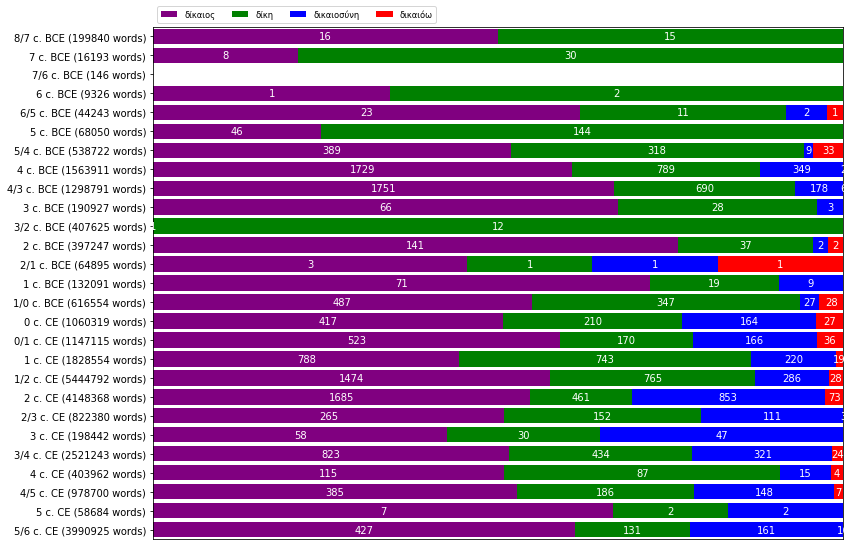

In [214]:
fig = plot_ratios(subselections_df, "date_string")

# Subcorpora

In [34]:
mask_pair_dict = {
    "AGT_christian" : {"column": "provenience", "value" : "christian"},
    "AGT_pagan" : {"column": "provenience", "value" : "pagan"},
    "AGT_philo" : {"column" : "author_id", "value" : "tlg0018"},
    "AGT_josephus" : {"column" : "author_id", "value" : "tlg0526"},
    "AGT_septuagint" : {"column" : "author_id", "value" : "tlg0527"},
    }

In [ ]:
AGT_josephus = AGT[AGT["author_id"]=="tlg0018"]

In [33]:
AGT[AGT["author_id"]=="tlg0526"][["author", "title", "wordcount"]]

,author,title,wordcount
829,Flavius Josephus,Antiquitates Judaicae; Machine readable text; ...,312038
830,Flavius Josephus,Josephi vita; Machine readable text; Flavii Io...,15783
831,Flavius Josephus,Contra Apionem; Machine readable text; Flavii ...,22742
832,Flavius Josephus,De bello Judaico libri vii; Machine readable t...,125289


In [29]:
AGT_philo = AGT[AGT["author_id"]=="tlg0018"]
AGT_philo.head(5)

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,wordcount,lemmata,lemmata_wordcount,lemmatized_sentences
310,tlg0018.tlg001.opp-grc1.xml,Philo Judaeus,De opificio mundi; Philonis Alexandri Opera Qu...,ΦIΛΩΝΟΣ ΠΕΡΙ ΤΗΣ ΚΑTΑ ΜΩΥΣΕΑ ΚΟΣΜΟΠΟΙΙΑΣ I p. ...,tlg0018,tlg0018.tlg001,1 B.C.-A.D. 1,0.0,"{'-0.5': 0.5, '0.5': 0.5}",0.5,jewish,25373,"[φλωνος, καα, μωυσεα, κοσμοποιιας, νομοθέτης, ...",10201,"[[φλωνος, καα, μωυσεα, κοσμοποιιας], [νομοθέτη..."
311,tlg0018.tlg002.opp-grc1.xml,Philo Judaeus,Legum allegoriarum libri i‑iii; Philonis Alexa...,ΝΟΜΩΝ ΙΕΡΩΝ ΑΛΛΗΓΟΡΙΑΣ ΤΩΝ ΜΕΤΑ ΤΗΝ ΕΞΑΗΜΕΡΟΝ ...,tlg0018,tlg0018.tlg002,1 B.C.-A.D. 1,0.0,"{'-0.5': 0.5, '0.5': 0.5}",0.5,jewish,44765,"[νομή, ἱερή, αλληγοριας, ἄτη, εξαημερον, πρότε...",18468,"[[νομή, ἱερή, αλληγοριας, ἄτη, εξαημερον, πρότ..."
312,tlg0018.tlg003.opp-grc1.xml,Philo Judaeus,De Cherubim; Philonis Alexandri Opera Quae Sup...,ΠΕΡΙ ΤΩΝ ΧΕΡΟΥΒΙΜ ΚΑΙ ΤΗΣ ΦΛΟΓΙΝΗΣ ΡΟΜΦΑΙΑΣ KA...,tlg0018,tlg0018.tlg003,1 B.C.-A.D. 1,0.0,"{'-0.5': 0.5, '0.5': 0.5}",0.5,jewish,13060,"[χερουβιμ, ἀκή, φλογινης, ῥομφαία, κτισθεντος,...",5427,"[[χερουβιμ, ἀκή, φλογινης, ῥομφαία, κτισθεντος..."
313,tlg0018.tlg004.opp-grc1.xml,Philo Judaeus,De sacrificiis Abelis et Caini; Philonis Alexa...,ΠΕΡΙ ΓΕΝΕΣΕΩΣ ΑΒΕΛ ΚΑΙ ΩΝ ΑΥΤΟΣ TE ΚΑΙ ΑΔΕΛΦΟΣ...,tlg0018,tlg0018.tlg004,1 B.C.-A.D. 1,0.0,"{'-0.5': 0.5, '0.5': 0.5}",0.5,jewish,23976,"[γένεσις, αβελ, ἀκή, ὠνή, ἀκή, ἀδελφός, καινός...",7681,"[[γένεσις, αβελ, ἀκή, ὠνή, ἀκή, ἀδελφός, καινό..."
314,tlg0018.tlg005.opp-grc1.xml,Philo Judaeus,Quod deterius potiori insidiari soleat; Philon...,ΠΕΡΙ ΤΟΥ TO XEIPON ΤΩΙ KPEITTONI ΦIΛEIN EΠITΙΘ...,tlg0018,tlg0018.tlg005,1 B.C.-A.D. 1,0.0,"{'-0.5': 0.5, '0.5': 0.5}",0.5,jewish,16085,"[φλ, πιθσθαι, εἶπον, κάιν, ἀδελφός, διέρχομαι,...",6908,"[[φλ, πιθσθαι, εἶπον, κάιν, ἀδελφός, διέρχομαι..."


In [7]:
AGTc = AGT[AGT["provenience"]=="christian"]
AGTc.head()

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,wordcount
379,tlg0031.tlg001.perseus-grc2.xml,None,New Testament - Matthew; Machine readable text...,ΚΑΤΑ ΜΑΘΘΑΙΟΝ ΒΙΒΛΟΣ γενέσεως Ἰησοῦ Χριστοῦ υἱ...,tlg0031a,tlg0031.tlg001,A.D. 1,0.5,{'0.5': 1},0.5,christian,18289
380,tlg0031.tlg002.perseus-grc2.xml,None,New Testament - Mark; Machine readable text; T...,ΚΑΤΑ ΜΑΡΚΟΝ ΑΡΧΗ τοῦ εὐαγγελίου Ἰησοῦ Χριστοῦ ...,tlg0031b,tlg0031.tlg002,A.D. 1,0.5,{'0.5': 1},0.5,christian,11277
381,tlg0031.tlg003.perseus-grc2.xml,Luke (the evangelist),New Testament - Luke; Machine readable text; T...,ΚΑΤΑ ΛΟΥΚΑΝ ΕΠΕΙΔΗΠΕΡ ΠΟΛΛΟΙ ἐπεχείρησαν ἀνατά...,tlg0031luke,tlg0031.tlg003,A.D. 1,0.5,{'0.5': 1},0.5,christian,19460
382,tlg0031.tlg004.perseus-grc2.xml,Johnannine literature,New Testament - John; Machine readable text; T...,"ΚΑΤΑ ΙΩΑΝΗΝ ΕΝ ΑΡΧΗ ἦν ὁ λόγος, καὶ ὁ λόγος ἦν...",tlg0031john,tlg0031.tlg004,A.D. 1,0.5,{'0.5': 1},0.5,christian,15592
383,tlg0031.tlg005.perseus-grc2.xml,Luke (the evangelist),New Testament - Acts; Machine readable text; T...,πράξεις ἀποστόλων τὸν μὲν πρῶτον λόγον ἐποιησά...,tlg0031luke,tlg0031.tlg005,A.D. 1,0.5,{'0.5': 1},0.5,christian,18408


In [8]:
len(AGTc)

147

In [13]:
AGTc.sort_values("date_avr", inplace=True)

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
set_with_dataframe(ECCE_AGT_overview.add_worksheet("AGTc_works", cols=1, rows=1), AGTc.drop("string", axis=1)) 

In [14]:
len(AGTc["author_id"].unique().tolist())

48

In [15]:
AGTc["author"].unique().tolist()

[None,
 'Clemens Romanus',
 'Johnannine literature',
 'Paul of Tarsus',
 'Luke (the evangelist)',
 'Polycarp',
 'Ignatius Antiochenus',
 'Barnabas',
 'Athenagoras',
 'Justin Martyr',
 'Justinus Martyr',
 'Maximus of Tyre',
 'Anonymus',
 'Dionysius Corinthius',
 'Hermas, 2nd cent.',
 'Tatianus',
 'Theophilus Antiochenus',
 'Irenaeus',
 'Origen',
 'Origenes',
 'Clement of Alexandria',
 'Hippolytus',
 'Anonymous',
 'Gregorius Nazianzenus',
 'Basil, Saint, Bishop of Caesarea',
 'Pseudo-Justinus Martyr',
 'Eusebius',
 'Eusebius of Caesarea',
 'Epiphanius',
 'pseudo-Menander',
 'Athanasius of Alexandria',
 'Athanasius',
 'Theodoretus',
 'Philostorgius',
 'Theodoret, Bishop of Cyrus',
 'Socrates, Scholasticus',
 'Philip Edward Pusey',
 'Sozomenus, Salaminius Hermias',
 'Zosimus',
 'Evagrius, Scholasticus',
 'Joannes Philoponus']

# Dik* in raw string

In [24]:
AGTc.iloc[0]["string"].count(" δικ")

16